

# Propaganda, start the `spark` session

> For SQL users, Spark SQL provides state-of-the-art SQL performance and maintains compatibility with Shark/Hive. In particular, like Shark, Spark SQL supports all existing Hive data formats, user-defined functions (UDF), and the Hive metastore.

> For Spark users, Spark SQL becomes the narrow-waist for manipulating (semi-) structured data as well as ingesting data from sources that provide schema, such as JSON, Parquet, Hive, or EDWs. It truly unifies SQL and sophisticated analysis, allowing users to mix and match SQL and more imperative programming APIs for advanced analytics.

> For open source hackers, Spark SQL proposes a novel, elegant way of building query planners. It is incredibly easy to add new optimizations under this framework.

> Internally, a structured query is a Catalyst tree of (logical and physical) relational operators and expressions.




In [1]:
# import the usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import timeit

%matplotlib inline
import seaborn as sns

sns.set_context("notebook", font_scale=1.2)

During the session, we will use classes and functions exported by `pyspark`


In [2]:
# spark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import col
import pyspark.sql.functions as fn
from pyspark.sql.catalog import Catalog
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import IntegerType, StringType

Start the `SparkSession`

In [3]:
conf = SparkConf().setAppName("Spark SQL Illustrations")
sc = SparkContext(conf=conf)

spark = (SparkSession
    .builder
    .appName("Spark SQL")
    .getOrCreate()
)

US Baby Names 1880-2017
=======================


Description
: US baby names provided by the SSA. 

This dataset contains all names used
for at least 5 children of either sex during a year. 


The file is made of `1924665` lines and  4 columns.

```
|-- name: string (nullable = true)
    |-- n: integer (nullable = true)
    |-- sex: string (nullable = true)
    |-- year: integer (nullable = true)
```

Each row indicates for a given name, sex, and year the number of babies 
of the given sex who were given that name during the given year. Names 
with less than 5 occurrences during the year were note recorded. 

|    name|  n|sex|year|
|:--------|:---:|:---:|:----:|
|  Emilia|112|  F|1985|
|   Kelsi|112|  F|1985|
|  Margot|112|  F|1985|
|  Mariam|112|  F|1985|
|Scarlett|112|  F|1985|

First, we download the data if it's not there yet

In [4]:
import requests, zipfile, io
from pathlib import Path

path = Path('babynames_short.csv')
if not path.exists():
    url = "https://stephanegaiffas.github.io/big_data_course/data/babynames_short.csv.zip"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path='./')

Load `babynames` from a `csv` file

In [5]:
df_sp = spark.read\
             .format('csv')\
             .option("header", "true")\
             .option("mode", "FAILFAST")\
             .option("inferSchema", "true")\
             .option("sep", ",")\
             .load("babynames_short.csv")




Ensure that the dataframe has the following schema:

    root
        |-- name: string (nullable = true)
        |-- n: integer (nullable = true)
        |-- sex: string (nullable = true)
        |-- year: integer (nullable = true)




In [6]:
df_sp.printSchema()

root
 |-- name: string (nullable = true)
 |-- n: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- year: double (nullable = true)



SQL versus spark-Dataframe API
=================================

>  Dataset API vs SQL

> Spark SQL supports two "modes" to write structured queries: Dataset API and SQL. SQL Mode is used to express structured queries using SQL statements using SparkSession.sql operator, expr standard function and spark-sql command-line tool.

> Some structured queries can be expressed much easier using Dataset API, but there are some that are only possible in SQL. In other words, you may find mixing Dataset API and SQL modes challenging yet rewarding.

> What is important, and one of the reasons why Spark SQL has been so successful, is that there is no performance difference between the modes. Whatever mode you use to write your structured queries, they all end up as a tree of Catalyst relational data structures. And, yes, you could consider writing structured queries using Catalyst directly, but that could quickly become unwieldy for maintenance (i.e. finding Spark SQL developers who could be comfortable with it as well as being fairly low-level and therefore possibly too dependent on a specific Spark SQL version).

Warmup:  compute the 10 most popular names given to babies in year 2000.
======================================================================

## Using `spark.sql()`

In order to use mode `sql`, create a temporary view from the `DataFrame`.

1. What are temporary views made of?
1. Are there other kind of views in spark's world?

In [7]:
df_sp.createOrReplaceTempView("table")
Catalog(spark).listTables()

[Table(name='table', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [8]:
# TODO: 
#There are also global temporary views and permanent view


## A query is a plain SQL query embodied in a string.



In [9]:
query = "SELECT name FROM table WHERE year=2000 ORDER BY n DESC LIMIT 10"

spark.sql(query).show()

#Using format string:

query2 = "SELECT name FROM table WHERE year={} ORDER BY n DESC LIMIT {}"

spark.sql(query2.format(2000,10)).show()

+-----------+
|       name|
+-----------+
|      Jacob|
|    Michael|
|    Matthew|
|     Joshua|
|      Emily|
|Christopher|
|   Nicholas|
|     Andrew|
|     Hannah|
|     Joseph|
+-----------+

+-----------+
|       name|
+-----------+
|      Jacob|
|    Michael|
|    Matthew|
|     Joshua|
|      Emily|
|Christopher|
|   Nicholas|
|     Andrew|
|     Hannah|
|     Joseph|
+-----------+




> This phrasing is not consistent with the DRY principle. Fix this using formatted strings.

## Using the dataframe/dataset API

This can also be done using Spark SQL API.

### Pedestrian approach

1. First select `10` most popular names for girls in year `2000`, define `spark` dataframe
`top10_2000_f`.
1. Does the definition of `top10_2000_f` involve _transformations_, _actions_ or both?
1. What is the type of the result returned by `top10_2000_f.take(2)`? the type of elements of the result?



In [10]:
# top10_2000_f = TODO:
top10_2000_f=df_sp.orderBy(df_sp.n.desc()).select("name").where("sex='F'").where("year=2000").limit(10)
top10_2000_f.show()

+---------+
|     name|
+---------+
|    Emily|
|   Hannah|
|  Madison|
|   Ashley|
|    Sarah|
|   Alexis|
| Samantha|
|  Jessica|
|Elizabeth|
|   Taylor|
+---------+




1. Do the same thing for boys.



In [11]:
# top10_2000_m = TODO:
top10_2000_m = df_sp.orderBy(df_sp.n.desc()).select("name").where("sex='M'").where("year=2000").limit(10)
top10_2000_m.show()

+-----------+
|       name|
+-----------+
|      Jacob|
|    Michael|
|    Matthew|
|     Joshua|
|Christopher|
|   Nicholas|
|     Andrew|
|     Joseph|
|     Daniel|
|      Tyler|
+-----------+




1. Compute the _union_ of the two spark dataframes. Store the result in
dataframe `top10_2000`



In [12]:
# top10_2000 = TODO:
top10_2000=top10_2000_f.union(top10_2000_m)
top10_2000.show()

+-----------+
|       name|
+-----------+
|      Emily|
|     Hannah|
|    Madison|
|     Ashley|
|      Sarah|
|     Alexis|
|   Samantha|
|    Jessica|
|  Elizabeth|
|     Taylor|
|      Jacob|
|    Michael|
|    Matthew|
|     Joshua|
|Christopher|
|   Nicholas|
|     Andrew|
|     Joseph|
|     Daniel|
|      Tyler|
+-----------+




### Do it again, complying  with DRY principle



In [13]:
# TODO:
query="SELECT name FROM table WHERE (sex='{sex}' AND year=2000) ORDER BY n DESC LIMIT 10"

spark.sql(query.format(sex='M')).union(spark.sql(query.format(sex='F'))).show()

+-----------+
|       name|
+-----------+
|      Jacob|
|    Michael|
|    Matthew|
|     Joshua|
|Christopher|
|   Nicholas|
|     Andrew|
|     Joseph|
|     Daniel|
|      Tyler|
|      Emily|
|     Hannah|
|    Madison|
|     Ashley|
|      Sarah|
|     Alexis|
|   Samantha|
|    Jessica|
|  Elizabeth|
|     Taylor|
+-----------+





Name portfolio through ages
===========================

1. Compute for each year and sex the number of distinct names given that year.



In [14]:
# nb_names_year_sex = TODO: 
nb_names_year_sex=df_sp.groupBy('year','sex').agg(fn.countDistinct('name').alias('countDistinctName')).orderBy(df_sp.year.desc())
nb_names_year_sex.show()

+------+---+-----------------+
|  year|sex|countDistinctName|
+------+---+-----------------+
|2017.0|  F|            18309|
|2017.0|  M|            14160|
|2016.0|  M|            14162|
|2016.0|  F|            18817|
|2015.0|  M|            14024|
|2015.0|  F|            19074|
|2014.0|  M|            14047|
|2014.0|  F|            19181|
|2013.0|  M|            14038|
|2013.0|  F|            19231|
|2012.0|  M|            14234|
|2012.0|  F|            19498|
|2011.0|  M|            14343|
|2011.0|  F|            19560|
|2010.0|  M|            14256|
|2010.0|  F|            19811|
|2009.0|  F|            20179|
|2009.0|  M|            14523|
|2008.0|  M|            14613|
|2008.0|  F|            20457|
+------+---+-----------------+
only showing top 20 rows




1. Plot the evolution of the number of distinct names as a function of `year`.
Use some aesthetics to distinguish sexes.




Text(0.5, 1.0, 'Evolution of the number of distinct names as a function of year')

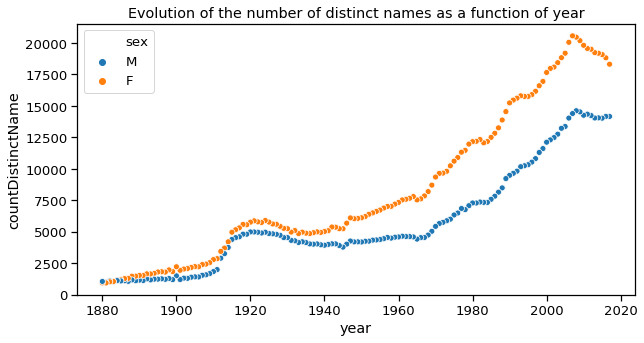

In [15]:
# TODO:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='year', y='countDistinctName',hue='sex',data=nb_names_year_sex.toPandas())
plt.title("Evolution of the number of distinct names as a function of year")



Assessing popularity through time
=================================

1. For each year and sex, compute the total number of births
1. Plot the evolution of the sex ratio over time
1. For each year, sex, and name compute the percentage of newborns
given that name for that given year.


> Use `Window` functions.



In [16]:
# TODO:
df2=df_sp.select("*").groupBy("year","sex").agg(fn.sum("n").alias("totalBirthsYearSex"))
df2.show()

+------+---+------------------+
|  year|sex|totalBirthsYearSex|
+------+---+------------------+
|1930.0|  M|           1097274|
|1935.0|  M|           1041103|
|1903.0|  F|            261971|
|1956.0|  F|           2007432|
|1892.0|  M|            122036|
|1995.0|  M|           1903185|
|1966.0|  M|           1783729|
|2006.0|  M|           2053406|
|1970.0|  F|           1748175|
|1889.0|  M|            110580|
|1924.0|  M|           1132783|
|1973.0|  M|           1559244|
|2008.0|  F|           1888607|
|1911.0|  M|            225970|
|1951.0|  M|           1882982|
|1921.0|  M|           1101463|
|1934.0|  F|           1044109|
|1898.0|  M|            122690|
|1910.0|  M|            194213|
|1953.0|  F|           1880924|
+------+---+------------------+
only showing top 20 rows



+------+---+------------------+---------------+-------------------+
|  year|sex|totalBirthsYearSex|totalBirthsYear|           sexRatio|
+------+---+------------------+---------------+-------------------+
|1988.0|  M|           1913203|        3693471|  0.517995944735995|
|1988.0|  F|           1780268|        3693471|  0.482004055264005|
|1951.0|  M|           1882982|        3683862| 0.5111434684578304|
|1951.0|  F|           1800880|        3683862| 0.4888565315421696|
|1976.0|  M|           1569843|        3034949| 0.5172551499217944|
|1976.0|  F|           1465106|        3034949| 0.4827448500782056|
|1940.0|  F|           1143393|        2302378|0.49661393567867657|
|1940.0|  M|           1158985|        2302378| 0.5033860643213234|
|1928.0|  F|           1153221|        2260839| 0.5100854151932093|
|1928.0|  M|           1107618|        2260839|0.48991458480679073|
|1900.0|  M|            150483|         450283|0.33419649420475567|
|1900.0|  F|            299800|         450283| 

Text(0.5, 1.0, 'Evolution of the sex ratio through time')

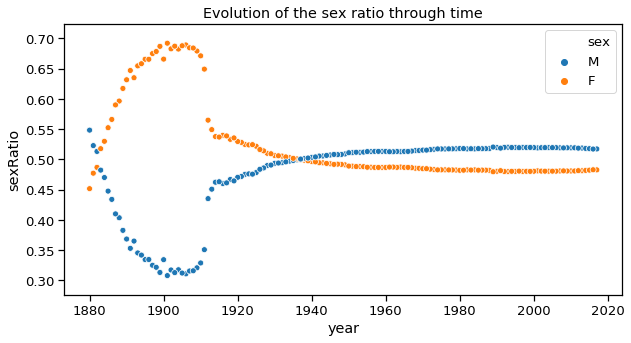

In [17]:
# %%
# TODO: plot sex ratio
df3=df_sp.select("*").groupBy("year").agg(fn.sum("n").alias("totalBirthsYear"))
df1=df2.join(df3,"year","outer")
df1=df1.withColumn("sexRatio",(df1.totalBirthsYearSex)/(df1.totalBirthsYear))
df1.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x="year",y="sexRatio",hue="sex",data=df1.toPandas())
plt.title("Evolution of the sex ratio through time")
# %%


1. Compute for each year, sex and name  the `row_number`, `rank`, and `dense_rank`
of the name within that year and sex category, when names are sorted by increasing popularity.



In [18]:
# TODO:
window1=Window.partitionBy("year","sex").orderBy(df_sp.n.asc())
row_number=fn.row_number().over(window1)
rank=fn.rank().over(window1)
dense_rank=fn.dense_rank().over(window1)
df_popularity=df_sp.withColumn("row_number",row_number).withColumn("rank",rank).withColumn("dense_rank",dense_rank)
df_popularity.show()


+--------+---+---+------+----------+----+----------+
|    name|  n|sex|  year|row_number|rank|dense_rank|
+--------+---+---+------+----------+----+----------+
|  Abbott|  5|  M|1930.0|         1|   1|         1|
|    Acel|  5|  M|1930.0|         2|   1|         1|
|   Adams|  5|  M|1930.0|         3|   1|         1|
|Agostino|  5|  M|1930.0|         4|   1|         1|
|   Albie|  5|  M|1930.0|         5|   1|         1|
| Alcario|  5|  M|1930.0|         6|   1|         1|
|    Alen|  5|  M|1930.0|         7|   1|         1|
| Alessio|  5|  M|1930.0|         8|   1|         1|
| Alfanso|  5|  M|1930.0|         9|   1|         1|
| Alfonsa|  5|  M|1930.0|        10|   1|         1|
|    Alga|  5|  M|1930.0|        11|   1|         1|
|    Alix|  5|  M|1930.0|        12|   1|         1|
|   Alley|  5|  M|1930.0|        13|   1|         1|
|   Almer|  5|  M|1930.0|        14|   1|         1|
|Alphonsa|  5|  M|1930.0|        15|   1|         1|
|   Alter|  5|  M|1930.0|        16|   1|     




Evolution of top popular names through the century
==================================================


1. For each sex, select the ten most popular names in year 2000, and plot the proportion
of newborns given that name over time. Take into account that some names might have
zero occurrence during certain years.



+-----------+------+-----+---+---------------+--------------------+
|       name|  year|    n|sex|totalBirthsYear|           prop_name|
+-----------+------+-----+---+---------------+--------------------+
|    Michael|1988.0|64133|  M|        3693471|0.017363883458134638|
|Christopher|1988.0|52996|  M|        3693471|0.014348562639316784|
|    Matthew|1988.0|45868|  M|        3693471|0.012418670675903506|
|     Joshua|1988.0|42649|  M|        3693471|0.011547132764816618|
|     Andrew|1988.0|35738|  M|        3693471| 0.00967599312408301|
|     Daniel|1988.0|34694|  M|        3693471|0.009393332179946721|
|     Joseph|1988.0|29003|  M|        3693471|0.007852505136767014|
|   Nicholas|1988.0|25291|  M|        3693471|0.006847488446504657|
|      Jacob|1988.0|15872|  M|        3693471| 0.00429731274457008|
|      Tyler|1988.0|13340|  M|        3693471|0.003611778730630...|
|    Michael|1951.0|72799|  M|        3683862|0.019761598018601133|
|     Joseph|1951.0|28156|  M|        3683862|0.

Text(0.5, 1.0, 'Proportion of newborns given a name from the ten most popular names in year 2000 over time for female')

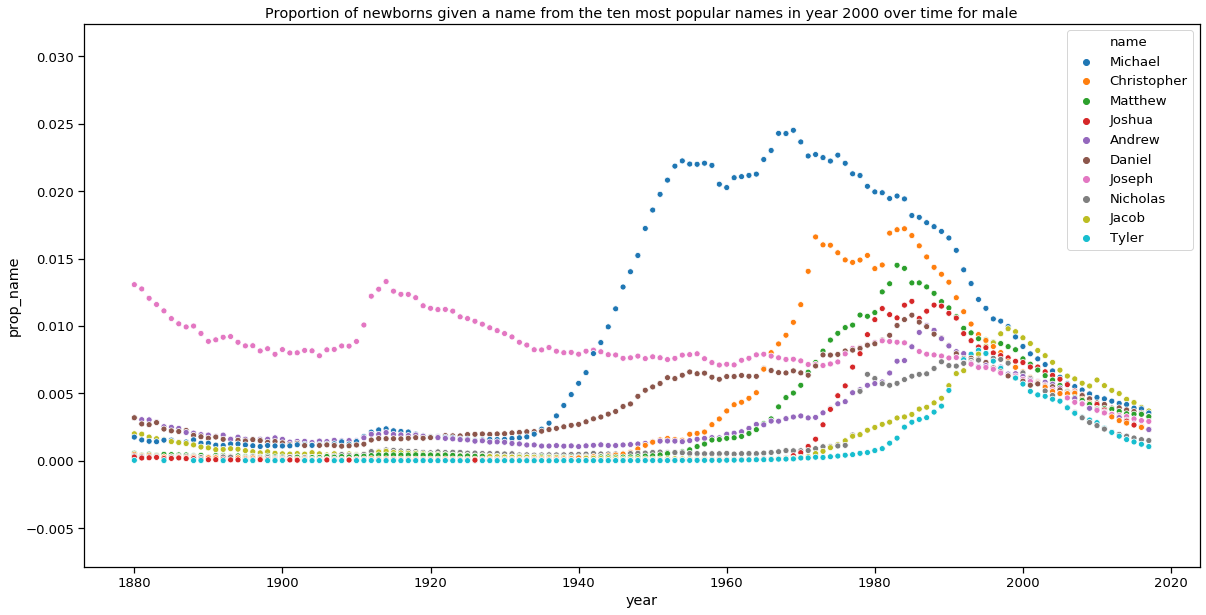

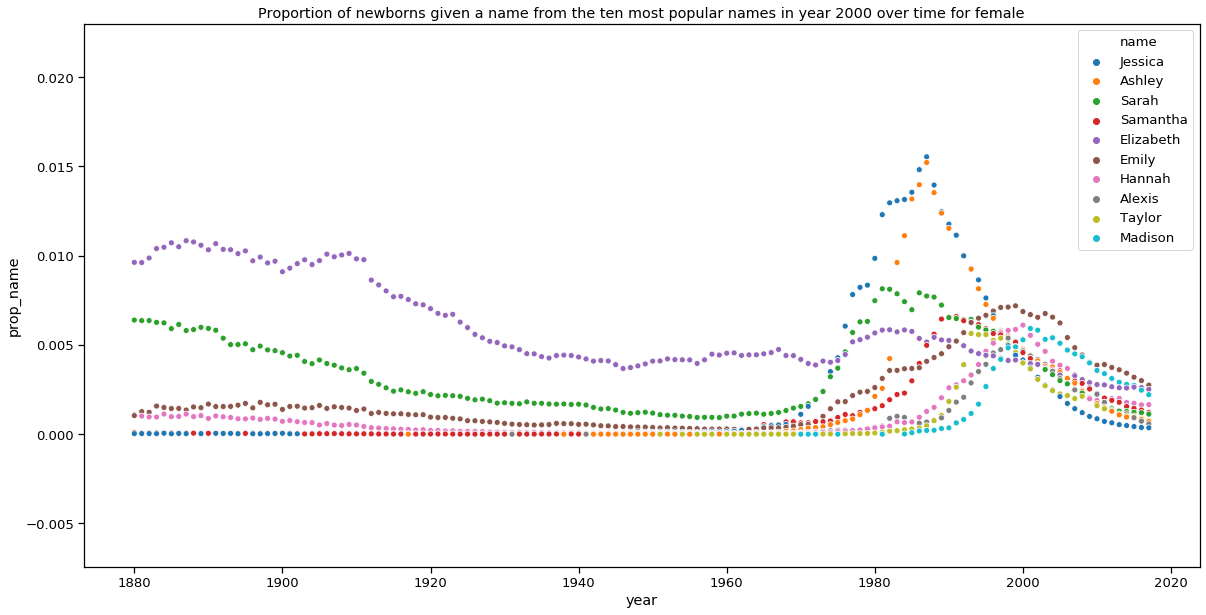

In [19]:
# TODO:

df10m=top10_2000_m.join(df_sp.where("sex='M'").join(df3,"year","outer"),"name")
df10m=df10m.withColumn("prop_name",df10m.n/df10m.totalBirthsYear)
df10m.show()
plt.figure(figsize=(20, 10))
sns.scatterplot(x="year",y="prop_name",hue="name",data=df10m.toPandas())
plt.title("Proportion of newborns given a name from the ten most popular names in year 2000 over time for male")

df10f=top10_2000_f.join(df_sp.where("sex='F'").join(df3,"year","outer"),"name")
df10f=df10f.withColumn("prop_name",df10f.n/df10f.totalBirthsYear)
df10f.show()

plt.figure(figsize=(20, 10))
sns.scatterplot(x="year",y="prop_name",hue="name",data=df10f.toPandas())
plt.title("Proportion of newborns given a name from the ten most popular names in year 2000 over time for female")

##### 1. Use `explain()` to determine the joining strategy used by spark.


Plot  the popularity of each of the top ten achievers from year 2000 with respect to time
==================================================================================




In [20]:
# %%
# TODO:
#COPY/PASTE ERROR: QUESTION 8 SAME AS QUESTION 7
# %%



Plot the total popularity of the top ten achievers from year 2000 with respect to time
==================================================================================




+------+--------------------+
|  year|     popularity_10_m|
+------+--------------------+
|1988.0| 0.09735665990067338|
|1951.0| 0.03743951320652076|
|1976.0| 0.07591000705448428|
|1940.0|0.018671564790837994|
|1928.0|0.016194872788376353|
|1900.0|0.013513723591607943|
|1979.0| 0.08774616699565069|
|1953.0|0.040029821703180604|
|1913.0|0.020628592986964338|
|1909.0|0.013710125423490104|
|1987.0| 0.09829450258475536|
|1959.0| 0.04082586178440462|
|1934.0|0.014723282897673832|
|1904.0|0.013088336980685965|
|1978.0| 0.08445348659911513|
|1968.0| 0.05669844054650127|
|1881.0| 0.02332170880557977|
|2010.0| 0.03990516704148264|
|1936.0| 0.01577666397737141|
|1889.0|0.016522118319686026|
+------+--------------------+
only showing top 20 rows

+------+--------------------+
|  year|     popularity_10_f|
+------+--------------------+
|1988.0|0.053757021511743296|
|1951.0|0.005803148977893309|
|1976.0|0.019241509494887718|
|1940.0|0.006670494592981692|
|1928.0| 0.00791166465192789|
|1900.0| 0.015

Text(0.5, 1.0, 'Total popularity of the top ten achievers female from year 2000 with respect to time')

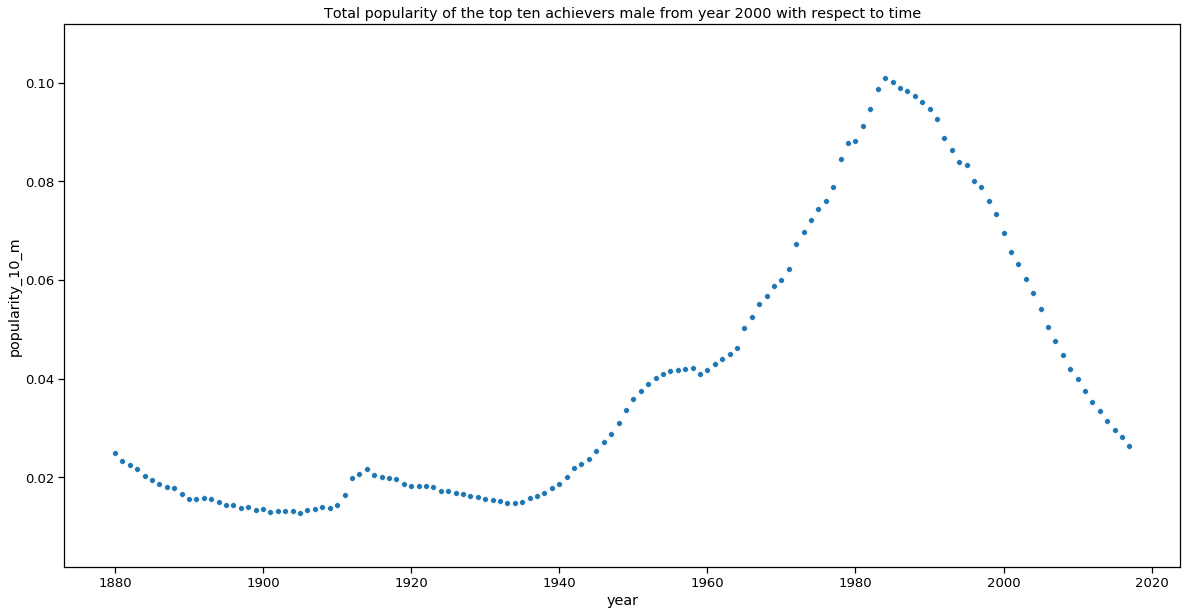

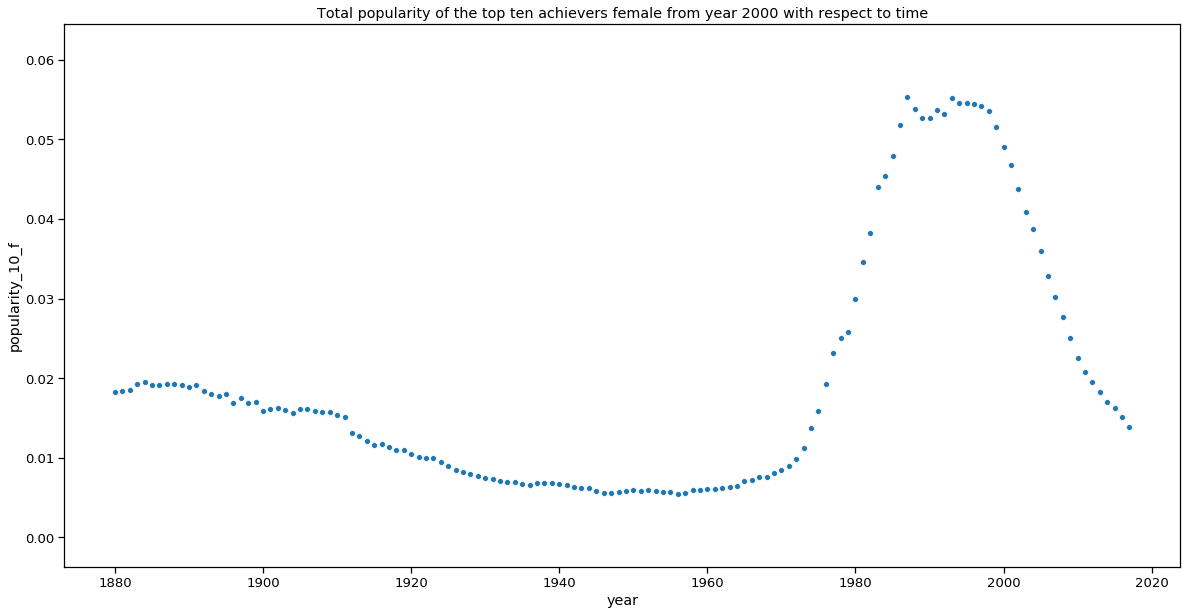

In [21]:
# TODO:
df_pop10_m=df10m.groupBy("year").agg(fn.sum("prop_name").alias("popularity_10_m"))
df_pop10_m.show()
plt.figure(figsize=(20,10))
sns.scatterplot(x="year",y="popularity_10_m",data=df_pop10_m.toPandas())
plt.title("Total popularity of the top ten achievers male from year 2000 with respect to time")

df_pop10_f=df10f.groupBy("year").agg(fn.sum("prop_name").alias("popularity_10_f"))
df_pop10_f.show()
plt.figure(figsize=(20,10))
sns.scatterplot(x="year",y="popularity_10_f",data=df_pop10_f.toPandas())
plt.title("Total popularity of the top ten achievers female from year 2000 with respect to time")



Plot lorenz curves
=====================

Every year, the name counts define a discrete probability distribution.
This distribution, just as income or wealth distribution,
is (usually) far from being uniform. We want to assess how uneven it is.
We use the tools developed in econometrics.

Without loss of generality, that we handle a distribution over $1, \ldots, n$
where $n$ is the number of distinct names given during a year.
We assume that frequencies $p_1, p_2, \ldots, p_n$ are given in ascending order.

The Lorenz function maps $[0, 1] \to [0, 1]$.
$$L(x) = \sum_{i=1}^{\lfloor nx \rfloor} p_i$$.

1. Design a query that adds a column "lorenz" to the dataframe , and for each
row computes the value of the Lorenz function defined by `year`  and `sex`.




In [22]:
# TODO:
window=Window.partitionBy("year","sex").orderBy("row_number").rangeBetween(Window.unboundedPreceding,0)
window2=Window.partitionBy("year","sex")
df_lorenz=df_popularity.join(df2,['year','sex'],"outer")
df_lorenz=df_lorenz.withColumn("p_i",df_lorenz.n/df_lorenz.totalBirthsYearSex)\
                    .withColumn("x",df_lorenz.row_number/fn.max("row_number").over(window2))\
                    .withColumn("lorenz",fn.sum("p_i").over(window))\
                    .select("year","sex","name","row_number","p_i","x","lorenz")
df_lorenz.show()

+------+---+--------+----------+--------------------+--------------------+--------------------+
|  year|sex|    name|row_number|                 p_i|                   x|              lorenz|
+------+---+--------+----------+--------------------+--------------------+--------------------+
|1930.0|  M|  Abbott|         1|4.556746993002659E-6|2.202158114952653...|4.556746993002659E-6|
|1930.0|  M|    Acel|         2|4.556746993002659E-6|4.404316229905307E-4|9.113493986005319E-6|
|1930.0|  M|   Adams|         3|4.556746993002659E-6|6.606474344857961E-4|1.367024097900797...|
|1930.0|  M|Agostino|         4|4.556746993002659E-6|8.808632459810614E-4|1.822698797201063...|
|1930.0|  M|   Albie|         5|4.556746993002659E-6|0.001101079057476327|2.278373496501329...|
|1930.0|  M| Alcario|         6|4.556746993002659E-6|0.001321294868971...|2.734048195801595...|
|1930.0|  M|    Alen|         7|4.556746993002659E-6|0.001541510680466...|3.189722895101861...|
|1930.0|  M| Alessio|         8|4.556746



1. Design a function that takes as input a `year` and plots the Lorenz curve
for that year for both sexes.



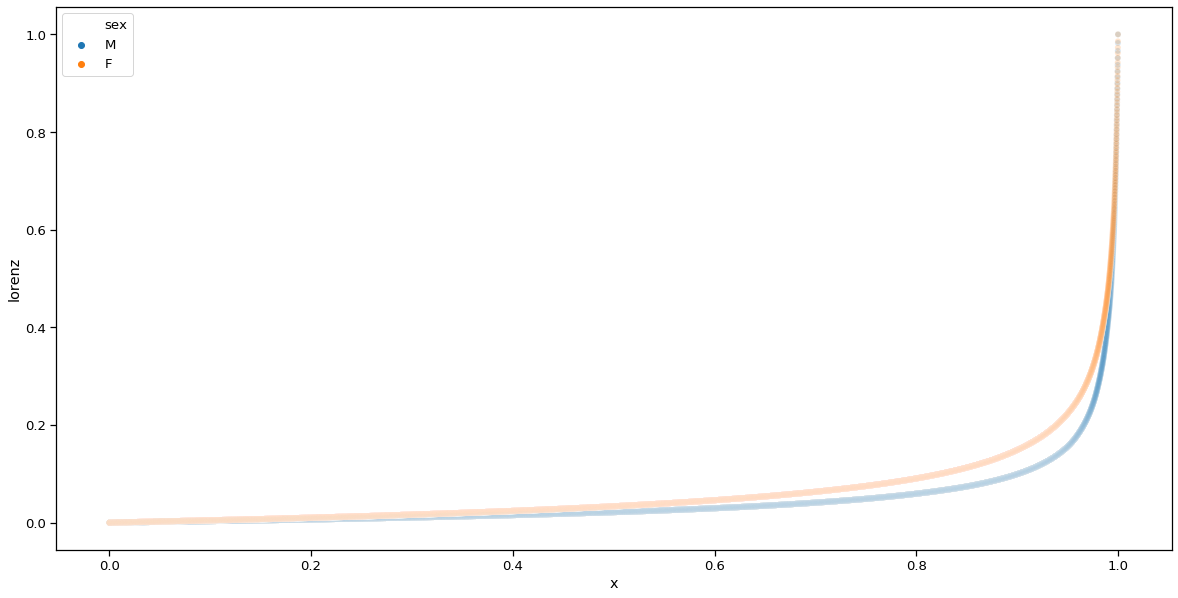

In [23]:

# TODO:
def plotLorenz(y):
    plt.figure(figsize=(20,10))
    sns.scatterplot(x="x",y="lorenz",hue="sex",alpha=0.2,data=df_lorenz.where("year={}".format(y)).toPandas())
    
plotLorenz(2000)



Gini index
==========

The [Gini index](https://en.wikipedia.org/wiki/Gini_coefficient) is twice the surface of the area comprised between curves $y=x$
and $y=L(x)$.

Choose a formula that allows you to compute it efficiently.

$$G={\frac {2\sum _{i=1}^{n}iy_{i}}{n\sum _{i=1}^{n}y_{i}}}-{\frac {n+1}{n}}.$$

1. Design a query that computes the Gini index of the `babynames` distribution
for every `year` and `sex`.

1. Plot Gini index over time




In [24]:
# TODO:
#G=(2*S1/n*S2)-(n+1)/n

window=Window.partitionBy("year","sex")

S1=fn.sum(col("row_number")*col("p_i")).over(window)
n=fn.max("row_number").over(window)
S2=fn.sum(col("p_i")).over(window)

df_gini=df_lorenz.withColumn("gini",((2*S1)/(n*S2))-(n+1)/n).select("year","sex","gini").distinct()
df_gini.show()


+------+---+------------------+
|  year|sex|              gini|
+------+---+------------------+
|1930.0|  M|0.9229152204263191|
|1935.0|  M|0.9227185874072288|
|1903.0|  F|0.8563364252132619|
|1892.0|  M|0.8459089745570789|
|1956.0|  F|0.9294801438696219|
|1966.0|  M|0.9376038513219436|
|1995.0|  M|0.9183686238424966|
|2006.0|  M|0.9017669259991026|
|1970.0|  F|0.9121613917768641|
|1889.0|  M|0.8427610965111711|
|1924.0|  M| 0.922652635431439|
|1911.0|  M|0.8601195273921411|
|1973.0|  M|0.9297498818522063|
|2008.0|  F|0.8570674373318774|
|1921.0|  M|0.9211544035340102|
|1951.0|  M|0.9430794206993773|
|1898.0|  M|0.8412978751912519|
|1934.0|  F|0.9134284622994839|
|1910.0|  M|0.8510262050708037|
|1953.0|  F|0.9301885739311129|
+------+---+------------------+
only showing top 20 rows



Text(0.5, 1.0, 'Gini index over time')

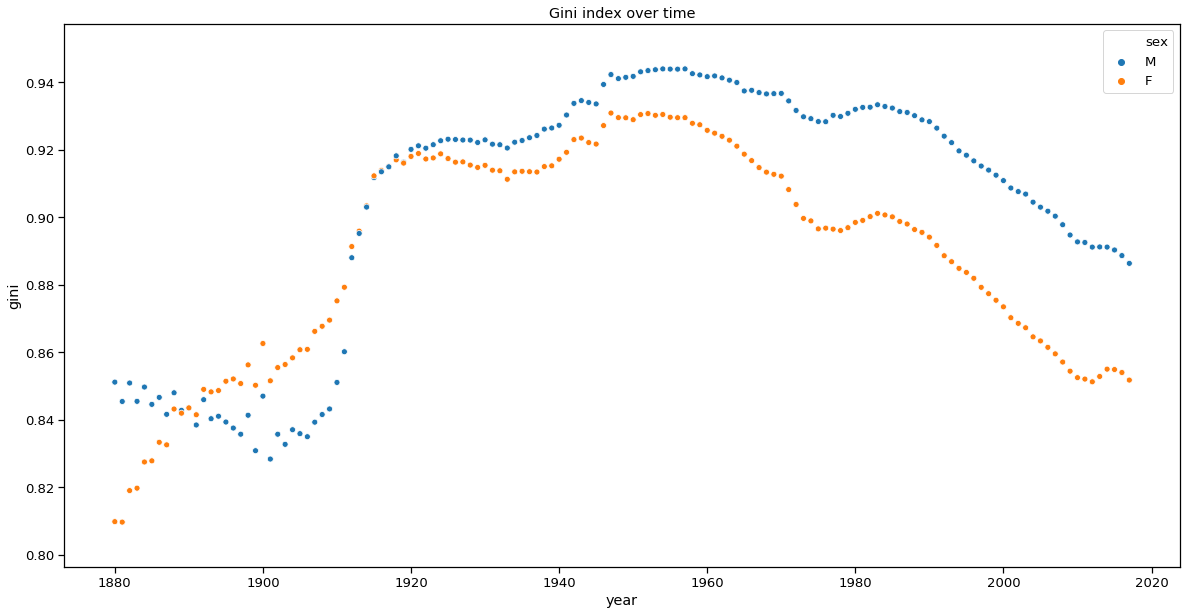

In [25]:
# TODO:
plt.figure(figsize=(20,10))
sns.scatterplot(x="year",y="gini",hue="sex",data=df_gini.toPandas())
plt.title("Gini index over time")




Close the door, leave work area clean
=====================================


In [26]:
spark.stop()